In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

In [2]:
SBOX = {
    0x0: 0x6,
    0x1: 0x4,
    0x2: 0xC,
    0x3: 0x5,
    0x4: 0x0,
    0x5: 0x7,
    0x6: 0x2,
    0x7: 0xE,
    0x8: 0x1,
    0x9: 0xF,
    0xA: 0x3,
    0xB: 0xD,
    0xC: 0x8,
    0xD: 0xA,
    0xE: 0x9,
    0xF: 0xB,
}

In [3]:
def apply_sbox(qc, a, out):
    """
    a   : 4 input qubits
    out : 4 output qubits (|0>)
    """
    for x in range(16):
        bits = [(x >> i) & 1 for i in range(4)]
        y = SBOX[x]
        ybits = [(y >> i) & 1 for i in range(4)]

        # Match input pattern
        for i, b in enumerate(bits):
            if b == 0:
                qc.x(a[i])

        # Write output
        for i, b in enumerate(ybits):
            if b == 1:
                qc.mcx(a, out[i])

        # Uncompute match
        for i, b in enumerate(bits):
            if b == 0:
                qc.x(a[i])

In [4]:
def grover_oracle(qc, key, target_key, phase):
    """
    Clean phase oracle:
    |x⟩|−⟩ → (−1 if x == target) |x⟩|−⟩
    """
    # Map target key to |1111⟩
    for i, bit in enumerate(target_key):
        if bit == 0:
            qc.x(key[i])

    # Phase kickback
    qc.mcx(key, phase)

    # Uncompute mapping
    for i, bit in enumerate(target_key):
        if bit == 0:
            qc.x(key[i])


In [5]:
def diffusion(qc, key):
    # Inversion about the mean
    qc.h(key)
    qc.x(key)

    # Convert MCX to phase flip
    qc.h(key[-1])
    qc.mcx(key[:-1], key[-1])
    qc.h(key[-1])

    qc.x(key)
    qc.h(key)


In [6]:
def reverse_counts(counts):
    reversed_counts = {}
    for bitstring, count in counts.items():
        reversed_bitstring = bitstring[::-1]
        reversed_counts[reversed_bitstring] = (
            reversed_counts.get(reversed_bitstring, 0) + count
        )
    return reversed_counts

In [7]:
# Known values
PLAINTEXT = [1, 0, 1, 1]
SECRET_KEY = [0, 0, 0, 1]

# Compute ciphertext classically
p = sum(PLAINTEXT[i] << i for i in range(4))
k = sum(SECRET_KEY[i] << i for i in range(4))
c = SBOX[p ^ k]
CIPHERTEXT = [(c >> i) & 1 for i in range(4)]


qc = QuantumCircuit(5, 4)
key = [0,1,2,3]
phase = 4

TARGET_KEY = SECRET_KEY  # example

qc.h(key)
qc.x(phase)
qc.h(phase)

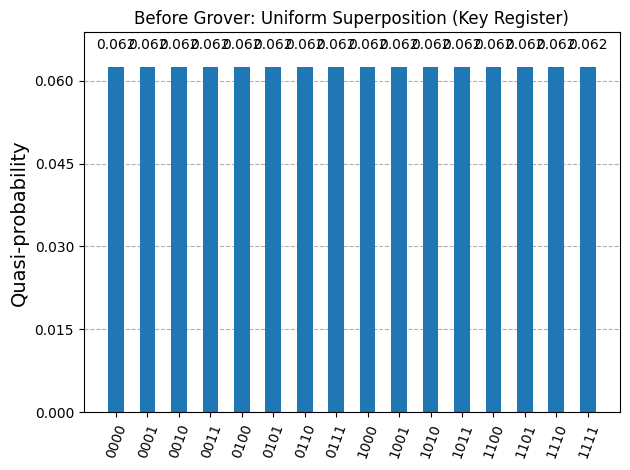

16
{np.str_('0000'): np.float64(0.06249999999999995), np.str_('0001'): np.float64(0.06249999999999995), np.str_('0010'): np.float64(0.06249999999999995), np.str_('0011'): np.float64(0.06249999999999995), np.str_('0100'): np.float64(0.06249999999999995), np.str_('0101'): np.float64(0.06249999999999995), np.str_('0110'): np.float64(0.06249999999999995), np.str_('0111'): np.float64(0.06249999999999995), np.str_('1000'): np.float64(0.06249999999999995), np.str_('1001'): np.float64(0.06249999999999995), np.str_('1010'): np.float64(0.06249999999999995), np.str_('1011'): np.float64(0.06249999999999995), np.str_('1100'): np.float64(0.06249999999999995), np.str_('1101'): np.float64(0.06249999999999995), np.str_('1110'): np.float64(0.06249999999999995), np.str_('1111'): np.float64(0.06249999999999995)}


In [8]:
# -------- BEFORE GROVER (uniform distribution) --------
qc_before = qc.copy()
sv_before = Statevector.from_instruction(qc_before)

# Keep only key qubits [0,1,2,3] and ignore phase qubit
probs_before = sv_before.probabilities_dict(qargs=[0, 1, 2, 3])

fig = plot_histogram(
    probs_before,
    title="Before Grover: Uniform Superposition (Key Register)"
)
display(fig)

In [9]:
for _ in range(3):
    grover_oracle(qc, key, TARGET_KEY, phase)
    diffusion(qc, key)

qc.measure(key, range(4))

{'0000': 1, '0001': 989, '1110': 2, '0110': 4, '1111': 3, '0111': 3, '1101': 4, '0010': 7, '0011': 2, '0100': 3, '1011': 2, '1000': 2, '0101': 2}


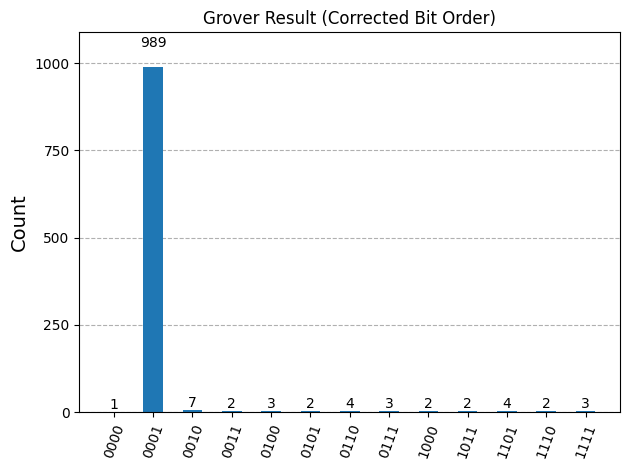

In [10]:
backend = AerSimulator()
tqc = transpile(qc, backend)
result = backend.run(tqc, shots=1024).result()

counts = result.get_counts()
counts = reverse_counts(counts)

print(counts)

from qiskit.visualization import plot_histogram
from IPython.display import display

fig = plot_histogram(
    counts,
    title="Grover Result (Corrected Bit Order)"
)
display(fig)
